# CSIRO Water Quality Analysis using Turbidity 

Maintainer: Xavier Ho <xavier.ho@csiro.au>

Please contact Xavier for any queries about this example.

This example uses the Analytics Execution Engine of AGDC v2 to query Landsat imagery. Two bands are combined to calculate an average, and the result is saved to an image.

In [3]:
from pprint import pprint
from datetime import datetime
import xarray as xr

import matplotlib
import matplotlib.image
%matplotlib inline

import datacube
from datacube.api import API, geo_xarray
from datacube.analytics.analytics_engine import AnalyticsEngine
from datacube.execution.execution_engine import ExecutionEngine
from datacube.analytics.utils.analytics_utils import plot

print('This example runs on Data Cube v2/{}.'.format(datacube.__version__))

This example runs on Data Cube v2/1.0.2+51.gd5a6f4b.


/usr/local/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-macosx-10.10-x86_64.egg/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


---

First, we make a query to the datacube to find out what datasets we have.

In [4]:
dc_a = AnalyticsEngine()
dc_e = ExecutionEngine()
dc_api = API()

print(dc_api.list_field_values('product')) # 'LEDAPS' should be in the list
print(dc_api.list_field_values('platform')) # 'LANDSAT_5' should be in the list

INFO:datacube.analytics.analytics_engine:Initialise Analytics Module.
INFO:datacube.execution.execution_engine:Initialise Execution Module.


[u'LEDAPS', u'nbar', u'pqa']
[u'LANDSAT_5']


Landsat Ecosystem Disturbance Adaptive Processing System (LEDAPS) is a NASA-funded project to map North American forest disturbance since 1975. We have datasets in the same format for Australia.

Let's find out what kind of datasets we have for Landsat 5.

In [6]:
query = {
    'product': 'LEDAPS',
    'platform': 'LANDSAT_5',
}
descriptor = dc_api.get_descriptor(query, include_storage_units=False)
pprint(descriptor)

{u'ls5_ledaps_albers': {'dimensions': [u'time', u'y', u'x'],
                        'irregular_indices': {u'time': array(['2011-10-17T00:15:48.000000000'], dtype='datetime64[ns]')},
                        'result_max': (numpy.datetime64('2011-10-17T00:15:48.000000000'),
                                       -3800012.5,
                                       899987.5),
                        'result_min': (numpy.datetime64('2011-10-17T00:15:48.000000000'),
                                       -4099987.5,
                                       600012.5),
                        'result_shape': (1, 12000, 12000),
                        'variables': {u'band1': {'datatype_name': dtype('int16'),
                                                 'nodata_value': -9999},
                                      u'band2': {'datatype_name': dtype('int16'),
                                                 'nodata_value': -9999},
                                      u'band3': {'datatype_name': 

For Landsat 5, Band 1-3 are Blue, Green, and Red visible light spectrum bands.

---

To set up the Engine, we first need to instantiate the modules and setup query parameters. 

> **`create_array`** sets up the platform and product we are interested in querying, as well as the bands (variables) of the satellite data set. We also limit the amount of data processed by a long-lat boundary and time.
> 
> **`apply_expression`** binds the variables into a generic string to execute, in this case an average of two bands.
>
> **`execute_plan`** is when the computation is actually run and returned.


In [13]:
dimensions = {
    'x': {
        'range': (140, 141)
    },
    'y': {
        'range': (-35.5, -36.5)
    },
    'time': {
        'range': (datetime(2011, 10, 17), datetime(2011, 10, 18))
    }
}

red = dc_a.create_array(('LANDSAT_5', 'LEDAPS'), ['band3'], dimensions, 'red')
green = dc_a.create_array(('LANDSAT_5', 'LEDAPS'), ['band2'], dimensions, 'green')
blue = dc_a.create_array(('LANDSAT_5', 'LEDAPS'), ['band1'], dimensions, 'blue')

Now we have created references to the green and blue bands, we can do simple band maths.

plot3D


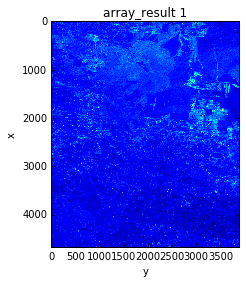

In [19]:
blue_result = dc_a.apply_expression([blue], 'array1', 'blue')
dc_e.execute_plan(dc_a.plan)
plot(dc_e.cache['blue'])

plot3D


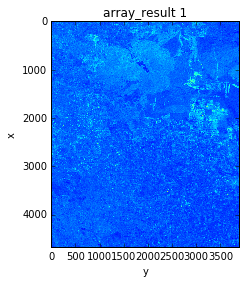

In [22]:
turbidity = dc_a.apply_expression([blue, green, red], '(array1 + array2 - array3) / 2', 'turbidity')

dc_e.execute_plan(dc_a.plan)
plot(dc_e.cache['turbidity'])

**`geo_xarray.reproject`** reprojects northings and eastings to longitude and latitude units.

Let's reproject the file into the common longitude-latitude projection, and save it to a picture.

<xarray.DataArray (y: 4406, x: 4626)>
array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ..., 
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]])
Coordinates:
    time     datetime64[ns] 2011-10-17T00:15:48
  * y        (y) float64 -35.45 -35.45 -35.45 -35.45 -35.45 -35.45 -35.45 ...
  * x        (x) float64 139.9 139.9 139.9 139.9 139.9 139.9 139.9 139.9 ...


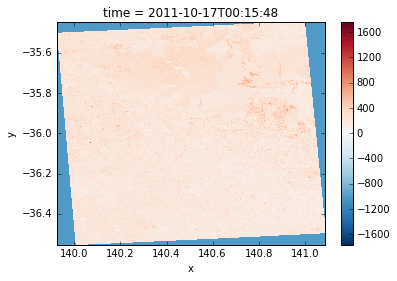

In [23]:
result = dc_e.cache['turbidity']['array_result']['turbidity']
reprojected = datacube.api.geo_xarray.reproject(result.isel(time=0), 'EPSG:3577', 'WGS84')

pprint(reprojected)

reprojected.plot.imshow()

matplotlib.image.imsave('turbidity.png', reprojected)

The boundaries in long-lat are as follows:

In [24]:
map(float, (reprojected.x[0], reprojected.x[-1], reprojected.y[0], reprojected.y[-1]))

[139.92372282115778,
 141.08644592491765,
 -35.44609059117283,
 -36.55351774101416]